# Project 2 :
### Which environmental and urban factors best predict flood risk, and how accurately can a machine learning model classify cities into high, medium, or low risk levels?

In [168]:
pip install xgboost 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


## 1. Load the dataset


In [170]:
df=pd.read_csv('urban_pluvial_flood_risk_dataset.csv')

In [171]:

print("Rows:", df.shape[0], "Columns:", df.shape[1])

Rows: 2963 Columns: 17


## Preview of the dataset

In [172]:
df.head()


,segment_id,city_name,admin_ward,latitude,longitude,catchment_id,elevation_m,dem_source,land_use,soil_group,drainage_density_km_per_km2,storm_drain_proximity_m,storm_drain_type,rainfall_source,historical_rainfall_intensity_mm_hr,return_period_years,risk_labels
0,SEG-00001,"Colombo, Sri Lanka",Borough East,6.920633,79.912600,CAT-136,NaN,Copernicus_EEA-10_v5,Institutional,NaN,4.27,160.5,CurbInlet,ERA5,39.4,50,monitor
1,SEG-00002,"Chennai, India",Ward D,13.076487,80.281774,CAT-049,-2.19,Copernicus_EEA-10_v5,Residential,D,7.54,NaN,OpenChannel,ERA5,56.8,25,ponding_hotspot|low_lying|event_2025-05-02
2,SEG-00003,"Ahmedabad, India",Sector 12,23.019473,72.638578,CAT-023,30.88,SRTM_3arc,Industrial,B,11.00,152.5,OpenChannel,IMD,16.3,5,monitor
3,SEG-00004,"Hong Kong, China",Sector 14,22.302602,114.078673,CAT-168,24.28,SRTM_3arc,Residential,B,7.32,37.0,Manhole,ERA5,77.0,10,monitor
4,SEG-00005,"Durban, South Africa",Sector 5,-29.887602,30.911008,CAT-171,35.70,SRTM_3arc,Industrial,C,4.50,292.4,OpenChannel,ERA5,20.8,5,monitor


### Features and Data types

In [173]:

pd.DataFrame(df.dtypes, columns=['Data Type'])

,Data Type
segment_id,object
city_name,object
admin_ward,object
latitude,float64
longitude,float64
catchment_id,object
elevation_m,float64
dem_source,object
land_use,object
soil_group,object


## 2. Data Cleaning and EDA

In [174]:
# Count missing values per column and sort descending
df.isnull().sum().sort_values(ascending=False)


soil_group                             362
rainfall_source                        315
drainage_density_km_per_km2            284
storm_drain_proximity_m                239
storm_drain_type                       178
elevation_m                            161
segment_id                               0
return_period_years                      0
historical_rainfall_intensity_mm_hr      0
land_use                                 0
city_name                                0
dem_source                               0
catchment_id                             0
longitude                                0
latitude                                 0
admin_ward                               0
risk_labels                              0
dtype: int64

In [175]:
flood_risk_df = df.drop([
    'segment_id',     # unique ID
    'city_name',      # high cardinality, not generalizable
    'dem_source',     # data provenance, not physical risk
    'rainfall_source',
    'admin_ward',
    'catchment_id',
    'rainfall_source',
    'dem_source'
      
], axis=1)

In [176]:
flood_risk_df = flood_risk_df.dropna(subset=['elevation_m', 'soil_group'])


In [177]:
flood_risk_df.head()

,latitude,longitude,elevation_m,land_use,soil_group,drainage_density_km_per_km2,storm_drain_proximity_m,storm_drain_type,historical_rainfall_intensity_mm_hr,return_period_years,risk_labels
1,13.076487,80.281774,-2.19,Residential,D,7.54,NaN,OpenChannel,56.8,25,ponding_hotspot|low_lying|event_2025-05-02
2,23.019473,72.638578,30.88,Industrial,B,11.00,152.5,OpenChannel,16.3,5,monitor
3,22.302602,114.078673,24.28,Residential,B,7.32,37.0,Manhole,77.0,10,monitor
4,-29.887602,30.911008,35.70,Industrial,C,4.50,292.4,OpenChannel,20.8,5,monitor
5,13.730254,100.441634,15.36,Roads,C,8.97,30.0,Manhole,120.5,50,extreme_rain_history


In [178]:
flood_risk_df = flood_risk_df.dropna()
flood_risk_df.isnull().sum()

latitude                               0
longitude                              0
elevation_m                            0
land_use                               0
soil_group                             0
drainage_density_km_per_km2            0
storm_drain_proximity_m                0
storm_drain_type                       0
historical_rainfall_intensity_mm_hr    0
return_period_years                    0
risk_labels                            0
dtype: int64

In [179]:
flood_risk_df['risk_labels'].value_counts()

risk_labels
monitor                                                            1283
low_lying                                                           242
extreme_rain_history                                                 82
sparse_drainage                                                      65
ponding_hotspot|low_lying                                            59
                                                                   ... 
ponding_hotspot|extreme_rain_history|low_lying|sparse_drainage        1
sparse_drainage|event_2024-11-13                                      1
extreme_rain_history|event_2022-09-24                                 1
low_lying|event_2025-05-25                                            1
ponding_hotspot|extreme_rain_history|low_lying|event_2025-06-09       1
Name: count, Length: 140, dtype: int64

In [180]:
flood_risk_df = flood_risk_df.dropna()


In [181]:
flood_risk_df.shape

(1922, 11)

In [182]:
flood_risk_df.nunique()

latitude                               1922
longitude                              1922
elevation_m                            1585
land_use                                  9
soil_group                                4
drainage_density_km_per_km2             778
storm_drain_proximity_m                1351
storm_drain_type                          4
historical_rainfall_intensity_mm_hr     729
return_period_years                       6
risk_labels                             140
dtype: int64

In [183]:
flood_risk_df['risk_labels'].value_counts(normalize=True)


risk_labels
monitor                                                            0.667534
low_lying                                                          0.125911
extreme_rain_history                                               0.042664
sparse_drainage                                                    0.033819
ponding_hotspot|low_lying                                          0.030697
                                                                     ...   
ponding_hotspot|extreme_rain_history|low_lying|sparse_drainage     0.000520
sparse_drainage|event_2024-11-13                                   0.000520
extreme_rain_history|event_2022-09-24                              0.000520
low_lying|event_2025-05-25                                         0.000520
ponding_hotspot|extreme_rain_history|low_lying|event_2025-06-09    0.000520
Name: proportion, Length: 140, dtype: float64

In [184]:
# Define valid labels
valid_labels = {'low_lying', 'ponding_hotspot', 'sparse_drainage', 'extreme_rain_history'}

In [185]:
flood_risk_df['risk_labels_list'] = flood_risk_df['risk_labels'].fillna('').apply(lambda x: x.split('|'))

In [186]:
#chat used to filter rows
mask = flood_risk_df['risk_labels_list'].apply(lambda labels: any(l in valid_labels for l in labels))
flood_risk_df = flood_risk_df[mask].reset_index(drop=True)


In [187]:
# Create binary flag columns for each valid label
for label in valid_labels:
    col_name = f"is_{label}"  # e.g., is_low_lying
    flood_risk_df[col_name] = flood_risk_df['risk_labels_list'].apply(lambda x: 1 if label in x else 0)

# Drop original text/list columns
flood_risk_df = flood_risk_df.drop(['risk_labels', 'risk_labels_list'], axis=1)

In [188]:
flood_risk_df.head()

,latitude,longitude,elevation_m,land_use,soil_group,drainage_density_km_per_km2,storm_drain_proximity_m,storm_drain_type,historical_rainfall_intensity_mm_hr,return_period_years,is_extreme_rain_history,is_ponding_hotspot,is_sparse_drainage,is_low_lying
0,13.730254,100.441634,15.36,Roads,C,8.97,30.0,Manhole,120.5,50,1,0,0,0
1,-33.930529,151.140718,-3.00,Commercial,B,10.62,70.9,CurbInlet,18.5,5,0,0,0,1
2,25.767890,-80.255953,3.29,Residential,D,7.63,153.6,CurbInlet,95.3,10,1,1,0,1
3,45.433867,-73.579360,4.25,Residential,D,3.27,11.2,GratedInlet,31.1,2,0,1,0,1
4,38.938489,-76.993755,-1.61,Mixed,B,6.64,11.2,Manhole,42.6,2,0,0,0,1


## EDA and Uncovering patterns 

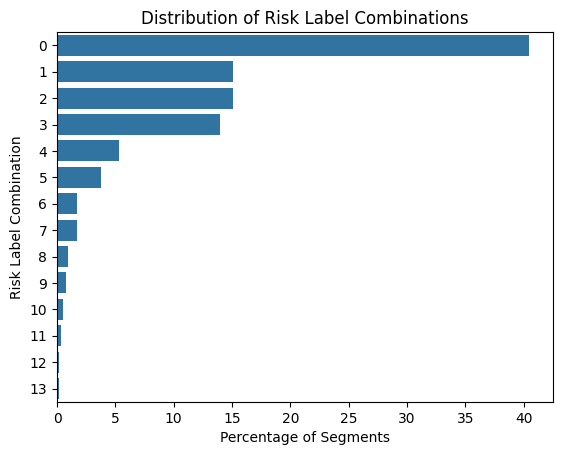

,is_low_lying,is_ponding_hotspot,is_sparse_drainage,is_extreme_rain_history,count,percent
0,1,0,0,0,258,40.50
1,0,0,1,0,96,15.07
2,1,1,0,0,96,15.07
3,0,0,0,1,89,13.97
4,1,1,0,1,34,5.34
5,1,0,1,0,24,3.77
6,0,1,0,1,11,1.73
7,1,0,0,1,11,1.73
8,1,1,1,0,6,0.94
9,0,0,1,1,5,0.78


In [189]:
combo_summary = (
    flood_risk_df[['is_low_lying','is_ponding_hotspot','is_sparse_drainage','is_extreme_rain_history']]
    .value_counts()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
)

total_rows = combo_summary['count'].sum()
combo_summary['percent'] = (combo_summary['count'] / total_rows * 100).round(2)

combo_summary


sns.barplot(
    data=combo_summary,
    x='percent', 
    y=combo_summary.index.astype(str),  # show combo as text
    
)
plt.xlabel("Percentage of Segments")
plt.ylabel("Risk Label Combination")
plt.title("Distribution of Risk Label Combinations")
plt.show()
combo_summary

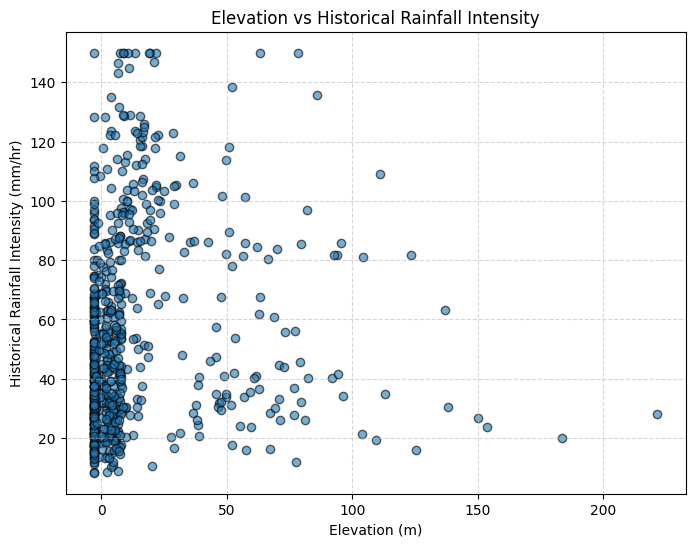

In [190]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(
    flood_risk_df['elevation_m'], 
    flood_risk_df['historical_rainfall_intensity_mm_hr'], 
    alpha=0.6, 
    edgecolor='k'
)
plt.xlabel("Elevation (m)")
plt.ylabel("Historical Rainfall Intensity (mm/hr)")
plt.title("Elevation vs Historical Rainfall Intensity")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


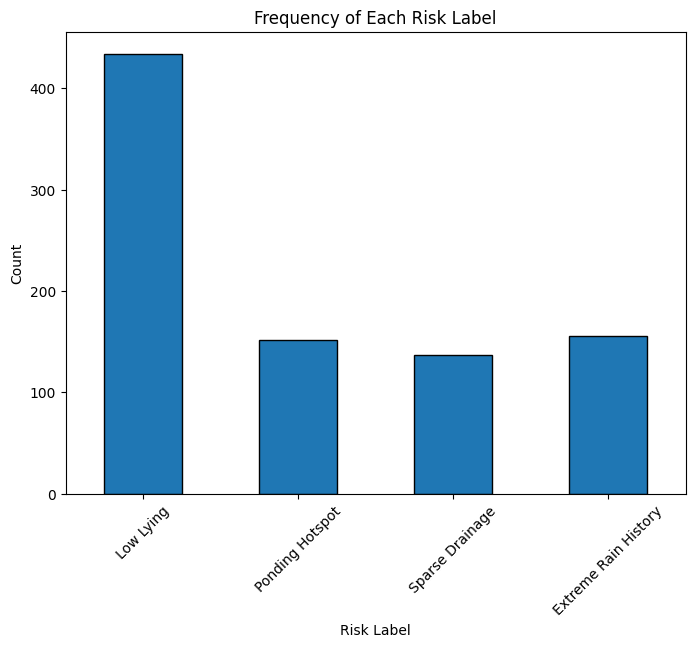

In [191]:
flood_risk_df[["is_low_lying", "is_ponding_hotspot", "is_sparse_drainage", "is_extreme_rain_history"]].sum().plot(
    kind="bar", figsize=(8,6), edgecolor="black"
)
plt.title("Frequency of Each Risk Label")
plt.ylabel("Count")
plt.xlabel("Risk Label")
plt.xticks([0,1,2,3], ["Low Lying", "Ponding Hotspot", "Sparse Drainage", "Extreme Rain History"], rotation=45)
plt.show()


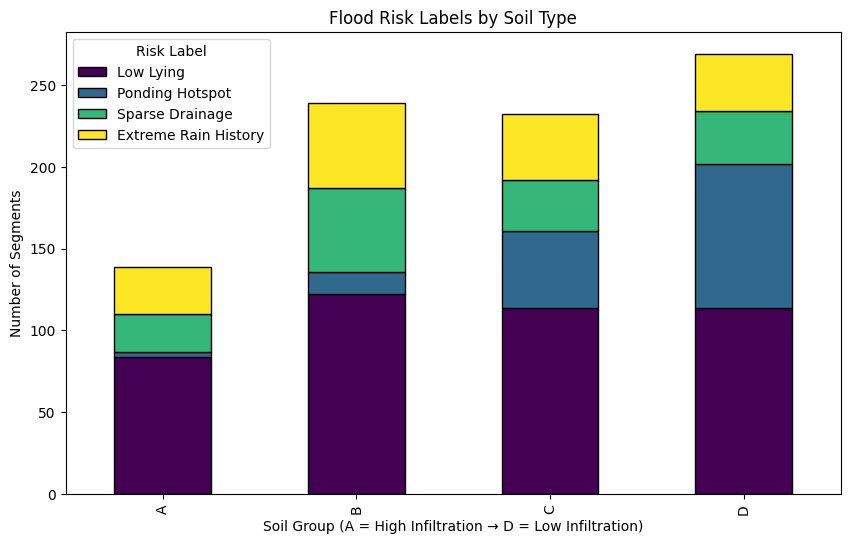

In [192]:
soil_risk = flood_risk_df.groupby("soil_group")[["is_low_lying", "is_ponding_hotspot", "is_sparse_drainage", "is_extreme_rain_history"]].sum()

ax = soil_risk.plot(
    kind="bar",
    stacked=True,
    figsize=(10,6),
    colormap="viridis",
    edgecolor="black"
)

plt.title("Flood Risk Labels by Soil Type")
plt.xlabel("Soil Group (A = High Infiltration → D = Low Infiltration)")
plt.ylabel("Number of Segments")

# Rename legend entries
new_labels = ["Low Lying", "Ponding Hotspot", "Sparse Drainage", "Extreme Rain History"]
ax.legend(title="Risk Label", labels=new_labels)

plt.show()

## Identifying Risk Types - Group into High, Medium, and Low

In [193]:
def assign_risk(row):
    if row["is_low_lying"] == 1 or row["is_ponding_hotspot"] == 1:
        return "High"
    elif row["is_sparse_drainage"] == 1:
        return "Medium"
    elif row["is_extreme_rain_history"] == 1:
        return "Medium"
    else:
        return "Low"

flood_risk_df['risk_level'] = flood_risk_df.apply(assign_risk, axis=1)

In [194]:
flood_risk_df[["is_low_lying", "is_ponding_hotspot", "is_sparse_drainage", "is_extreme_rain_history", "risk_level"]]


,is_low_lying,is_ponding_hotspot,is_sparse_drainage,is_extreme_rain_history,risk_level
0,0,0,0,1,Medium
1,1,0,0,0,High
2,1,1,0,1,High
3,1,1,0,0,High
4,1,0,0,0,High
...,...,...,...,...,...
632,1,0,0,0,High
633,1,1,0,1,High
634,1,0,0,0,High
635,1,1,0,0,High


## Training and Testing

In [195]:
# Build features (X) and target (y) WITHOUT leaking target-derived columns
# Drop the 'risk_level' target and the indicator columns that were derived from the original text labels
leak_cols = ['is_low_lying', 'is_ponding_hotspot', 'is_sparse_drainage', 'is_extreme_rain_history']
X = flood_risk_df.drop(columns=['risk_level'] + [c for c in leak_cols if c in flood_risk_df.columns])
y = flood_risk_df['risk_level']

# Show object columns to know which need encoding
print('Object columns in X:', X.select_dtypes(include=['object']).columns.tolist())

# Encode categorical columns (only if they exist)
X_encoded = X.copy()
label_encoders = {}
for col in ['land_use', 'soil_group', 'storm_drain_type']:
    if col in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        label_encoders[col] = le

# Split into train/test (stratify to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

Object columns in X: ['land_use', 'soil_group', 'storm_drain_type']


In [196]:
rf_model = RandomForestClassifier(n_estimators=200,max_depth=None ,random_state=42)

In [197]:
rf_model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

In [198]:
rf_preds = rf_model.predict(X_test)


In [199]:
print("----- Random Forest Results -----")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))

----- Random Forest Results -----
Accuracy: 0.984375
              precision    recall  f1-score   support

        High       1.00      0.98      0.99        90
      Medium       0.95      1.00      0.97        38

    accuracy                           0.98       128
   macro avg       0.97      0.99      0.98       128
weighted avg       0.99      0.98      0.98       128

Confusion Matrix:
 [[88  2]
 [ 0 38]]


----- Decision Tree Results -----
Accuracy: 0.953125
              precision    recall  f1-score   support

        High       0.98      0.96      0.97        90
      Medium       0.90      0.95      0.92        38

    accuracy                           0.95       128
   macro avg       0.94      0.95      0.94       128
weighted avg       0.95      0.95      0.95       128

Confusion Matrix:
 [[86  4]
 [ 2 36]]


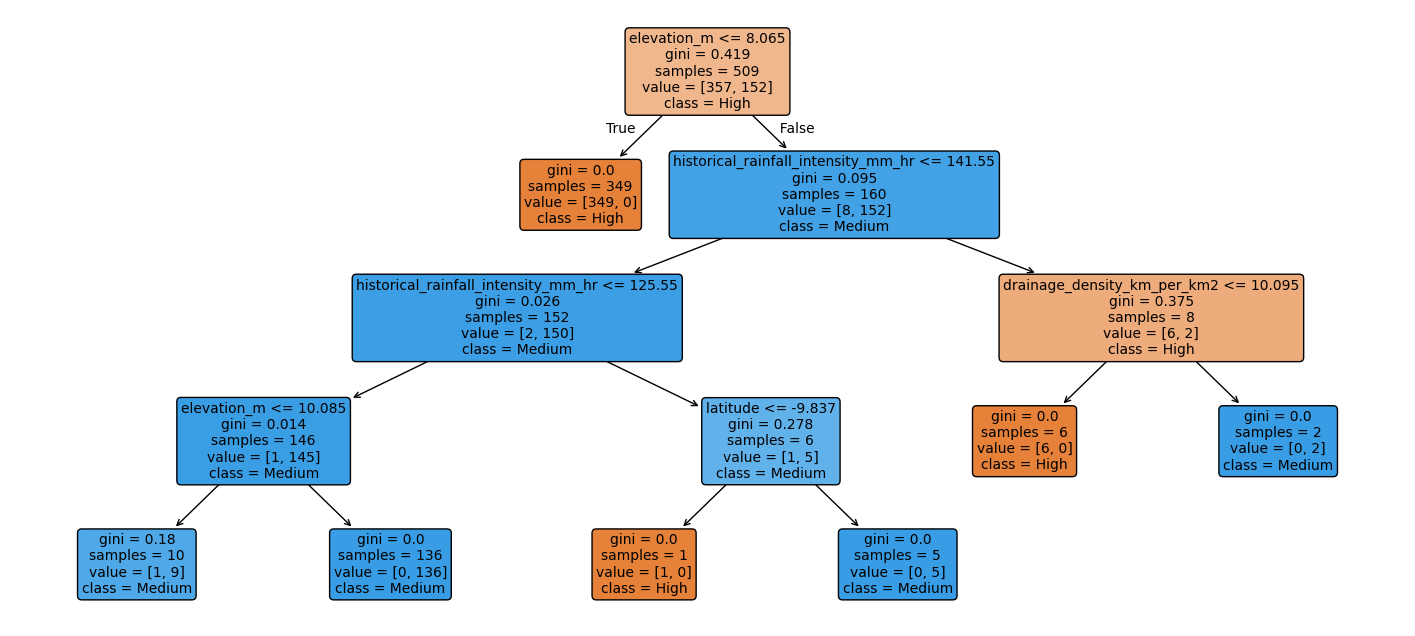

In [200]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Build the model
dt_model = DecisionTreeClassifier(
    criterion='gini',       # or 'entropy'
    max_depth=4,            # limit depth to avoid overfitting
    random_state=42
)

# Train
dt_model.fit(X_train, y_train)

# Predict
dt_preds = dt_model.predict(X_test)

# Evaluate
print("----- Decision Tree Results -----")
print("Accuracy:", accuracy_score(y_test, dt_preds))
print(classification_report(y_test, dt_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_preds))

# ----------------------------------------------------
# Visualize the tree
# ----------------------------------------------------
plt.figure(figsize=(18, 8))
plot_tree(
    dt_model,
    feature_names=X_train.columns,
    class_names=[str(cls) for cls in dt_model.classes_],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

In [201]:
print("----- XGBoost Results -----")

----- XGBoost Results -----
